<a href="https://colab.research.google.com/github/anilaksu/Algorithmic-Trading-Codes/blob/TankX-Real-Time-Arbitrage-Case/RealTimeArbitrage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TankX Real-Time Arbitrage Case**
## *Spring 2024*  
Anil Aksu    

*February 14th, 2024*  

Notebook Organization:

*   Getting FX data using Binance WebSockets

In [159]:
# Here we set our working directory in our google drive to access datasets externally
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/ColabNotebooks/TankX Real Time Arbitrage Case
!ls # special shell command to view the files in the home directory of the notebook environment

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/ColabNotebooks/TankX Real Time Arbitrage Case
BinanceTradingPairs.gsheet  BinanceTradingPairs.xlsx  RealTimeArbitrage.ipynb


#1. Getting Foreign Exchange (FX) data using Binance WebSockets


In [ ]:
# Here we setup websocket-client
!python3 -V
!which pip3
!pip3 install websocket-client --upgrade --no-cache-dir
!pip3 install python-binance --upgrade --no-cache-dir

Python 3.10.12
/usr/local/bin/pip3


In [119]:
# Here we import relevant packages
import pandas as pd                 # Pandas library for data organization and manupulation
import numpy as np
import collections                  # List operations
from datetime import datetime       # Importing datetime module
import pytz                         # pytz allows us to set timezone
import json                         # Json library helps us to retrieve online json formatted data
from itertools import permutations  # Allows us to check all potential triangular arbitrage opportunities for given list of trading pairs
import websocket

##1.1 Pair identification

In [ ]:
#Binance API keys

#API Key: fwHUTc5by0bc9a3U1PRN7FlzeDewcooIUm0yg9Uvk25IFNjOJGiQtv0sLOerMwME

#Secret Key: ZEeFQ8IBpQBZ1NXwviwvDmMT5zJEtCBq6AkI09cBPCpHZkVQnhmWB6Vb9IMGUPd3

In [250]:
def getTriangularArbitrageList(splitted_pairs):
  '''
    This function identifies all triangular arbitrage permutations by
    checking if 3 pairs form a set with size 3
  '''
  # Here we form all possible triangular arbitrage permutations
  tri_all_permutations = permutations([x for x in range(0, len(splitted_pairs))], 3)
  # List of an actual triangular pairs by index
  tri_arbitrage_list = []
  Nonexistant = True # Flag to indicate a permutation already exists in the triangular arbitrage list

  for permutation in tri_all_permutations:
    # Here order the permutation to make sure we don't add it more than one with different combination
    permutation_ordered = [list(permutation)[0], list(permutation)[1], list(permutation)[2]]
    # Here we form a set and check if it has 3 elements
    assets_permutation = [splitted_pairs[permutation_ordered[0]],
                              splitted_pairs[permutation_ordered[1]],splitted_pairs[permutation_ordered[2]]]
    all_assets = set().union(*assets_permutation)

    if len(all_assets) == 3:
      # Here we make sure the order forms a cycle such that [A/B, B/C, A/C]
      if(splitted_pairs[permutation_ordered[0]][1] == splitted_pairs[permutation_ordered[2]][0]):
        permutation_ordered = [list(permutation)[0], list(permutation)[2], list(permutation)[1]]
      elif(splitted_pairs[permutation_ordered[1]][1] == splitted_pairs[permutation_ordered[2]][0]):
        permutation_ordered = [list(permutation)[1], list(permutation)[2], list(permutation)[0]]
      elif(splitted_pairs[permutation_ordered[1]][1] == splitted_pairs[permutation_ordered[0]][0]):
        permutation_ordered = [list(permutation)[1], list(permutation)[0], list(permutation)[2]]
      elif(splitted_pairs[permutation_ordered[2]][1] == splitted_pairs[permutation_ordered[0]][0]):
        permutation_ordered = [list(permutation)[2], list(permutation)[0], list(permutation)[1]]
      elif(splitted_pairs[permutation_ordered[2]][1] == splitted_pairs[permutation_ordered[1]][0]):
        permutation_ordered = [list(permutation)[2], list(permutation)[1], list(permutation)[0]]
      else:
        continue # Here the order is correct and we leave it as it is

      # Here we check if a permutation already exists in the list
      for permutation in tri_arbitrage_list:
        if collections.Counter(permutation) == collections.Counter(permutation_ordered) :
          Nonexistant = False
        else:
          Nonexistant = True

      if Nonexistant:
        tri_arbitrage_list.append(permutation_ordered)
    # Here we remove repeating combinations

  return tri_arbitrage_list

In [203]:
# Top 500 Binance Trading Pairs based on their trading volume
binance_pairs = pd.read_excel('BinanceTradingPairs.xlsx', sheet_name= 'Final Pairs')['Binance Trading Pairs'].tolist()
# Here we split pairs to form a list of triangular arbitrage cycles
splitted_pairs = [s.split("/") for s in binance_pairs]
# We get all triangular arbitrage pairs
tri_arbitrage_list = getTriangularArbitrageList(splitted_pairs)

In [204]:
# Here we remove / in trading pairs because naming convention in WebSockets
binance_pairs = [s.replace('/', '') for s in binance_pairs]
# We form a list of triangular arbitrage to check real time and eliminate pairs which do not form a triangular arbitrage opportunity
triangular_pairs = [[binance_pairs[tri[0]], binance_pairs[tri[1]],
                     binance_pairs[tri[2]]] for tri in tri_arbitrage_list ]
# to convert lists to dictionary with splitted pairs to check if any triangular arbitrage opportunity shows later using getTriangularArbitrageList() function
pairs_dict = {binance_pairs[i]: splitted_pairs[i] for i in range(len(binance_pairs))}
# Here we reduce our list pairs to the ones forming an triangular arbitrage opportunity
pairs_refined = list(set().union(*triangular_pairs))
# Here we refine the pairs dictionary to the ones forming an triangular arbitrage opportunity
pairs_dict = {key: value for key, value in pairs_dict.items() if key in pairs_refined}
print("Number of pairs we track is: ", len(pairs_dict))

Number of pairs we track is:  244


##1.2 Create Socket URL

In [205]:
# Here we organize our merge our pairs and form socket name
all_pairs = [coin.lower() + '@bookTicker' for coin in pairs_refined] # Formatted list
all_pairs= '/'.join(all_pairs)                         # Joined list
socket = "wss://stream.binance.us:9443/ws/"+all_pairs
socket

'wss://stream.binance.us:9443/ws/usdcusdt@bookTicker/mantausdt@bookTicker/chzusdt@bookTicker/sklusdt@bookTicker/ftmusdt@bookTicker/arbfdusd@bookTicker/bonkusdt@bookTicker/soleth@bookTicker/shibusdt@bookTicker/dogebtc@bookTicker/veteth@bookTicker/btcusdc@bookTicker/solfdusd@bookTicker/xaitry@bookTicker/avaxfdusd@bookTicker/trbusdt@bookTicker/rndrusdt@bookTicker/chztry@bookTicker/flokitry@bookTicker/solusdc@bookTicker/btttry@bookTicker/avaxbtc@bookTicker/denttry@bookTicker/luncusdt@bookTicker/memetry@bookTicker/trxtry@bookTicker/gasbtc@bookTicker/rndrtry@bookTicker/opusdc@bookTicker/trxbtc@bookTicker/opbtc@bookTicker/ordibtc@bookTicker/shibtry@bookTicker/arpausdt@bookTicker/linketh@bookTicker/memeusdt@bookTicker/fetusdt@bookTicker/jtotry@bookTicker/nfpusdt@bookTicker/dogetry@bookTicker/bonktry@bookTicker/bnbtusd@bookTicker/fettry@bookTicker/ordiusdt@bookTicker/darusdt@bookTicker/maticusdt@bookTicker/orditry@bookTicker/bttusdt@bookTicker/bnbeur@bookTicker/xmrbtc@bookTicker/ltcbtc@bookTick

##1.2 Trade Socket

**Individual Symbol Book Ticker Streams**

**Change `ticker` to `pair` in data frames!!!**

**Payload:**

* `u`: order book updateId
* `s`: symbol
* `b`: best bid price
* `B`: best bid qty
* `a`: best ask price
* `A`: best ask qty

In [206]:
def manipulation(source):
  '''
    This function organizes message from WebSocket
  '''
  ticker = source['s']
  bid_price =source['b']
  ask_price =source['a']
  # Here we keep exact time and time up to second for further analysis
  event_time = datetime.now(pytz.timezone('Asia/Istanbul'))
  # Bid Data
  bid_data = pd.DataFrame(bid_price, columns = ['bid_price'], index = [event_time])
  bid_data['ticker'] = ticker
  bid_data.index.name = 'timestamp'
  bid_data['bid_price'] = bid_data['bid_price'].astype(float)
  bid_data = bid_data.reset_index()
  # Ask data
  ask_data = pd.DataFrame(bid_price, columns = ['ask_price'], index = [event_time])
  ask_data['ticker'] = ticker
  ask_data.index.name = 'timestamp'
  ask_data['ask_price'] = ask_data['ask_price'].astype(float)
  ask_data = ask_data.reset_index()
  # Merged Data for data pulling updates
  df = pd.merge(bid_data, ask_data, left_on=['timestamp','ticker'], right_on=['timestamp','ticker'], how='left')
  df = df[['timestamp', 'ticker', 'bid_price', 'ask_price']] # Here we reorder colums for convenience of the output
  print(df)                                                  # Here we output data for intermediate checks

  return bid_data, ask_data

In [231]:
df_bid = pd.DataFrame()
df_ask = pd.DataFrame()

def on_message(ws, message):
  message = json.loads(message)
  bid_data, ask_data = manipulation(message)
  global df_bid, df_ask                     # Here we access df dataframe globally
  df_bid = pd.concat([df_bid ,   bid_data]) # Here we update bid dataframe
  df_ask = pd.concat([df_ask ,   ask_data]) # Here we update bid dataframe

def on_error(ws, error):
  print(error)

def on_close(ws, close_status_code, close_msg):
  print("### closed ###")
  # Time Formatting for bid data
  df_bid['timestamp'] = pd.to_datetime(df_bid['timestamp'], unit = 'ms')
  df_bid['event_second'] = pd.to_datetime(df_bid['timestamp'].dt.strftime("%m/%d/%Y, %H:%M:%S"))
  # Time Formatting for bid data
  df_ask['timestamp'] = pd.to_datetime(df_ask['timestamp'], unit = 'ms')
  df_ask['event_second'] = pd.to_datetime(df_ask['timestamp'].dt.strftime("%m/%d/%Y, %H:%M:%S"))
  print(df_bid, df_ask)

def on_open(ws):
  print("Opened connection")

ws = websocket.WebSocketApp(socket,
                            on_open = on_open,
                            on_message = on_message,
                            on_error = on_error,
                            on_close = on_close)

In [232]:
ws.run_forever()

Opened connection
                         timestamp   ticker  bid_price  ask_price
0 2024-02-17 16:51:27.666399+03:00  BCHUSDT      263.7      263.7
                         timestamp   ticker  bid_price  ask_price
0 2024-02-17 16:51:27.780854+03:00  BCHUSDT      263.7      263.7
                         timestamp   ticker  bid_price  ask_price
0 2024-02-17 16:51:27.865393+03:00  SOLUSDC     106.89     106.89
                         timestamp   ticker  bid_price  ask_price
0 2024-02-17 16:51:27.882030+03:00  SOLUSDC     106.89     106.89
                         timestamp   ticker  bid_price  ask_price
0 2024-02-17 16:51:27.901285+03:00  LTCUSDT      69.26      69.26
                         timestamp   ticker  bid_price  ask_price
0 2024-02-17 16:51:27.917486+03:00  LTCUSDT      69.26      69.26
                         timestamp    ticker  bid_price  ask_price
0 2024-02-17 16:51:27.929601+03:00  LINKUSDT     19.558     19.558
                         timestamp   ticker  bid_price  

True

Here I write the raw data as csv file, which inludes data pulled for 2 and half hours

In [235]:
# Here we write the raw data
bid_file = 'BidDataRaw.csv'
ask_file = 'AskDataRaw.csv'
# saving the excel
df_bid.to_csv(bid_file)
df_ask.to_csv(ask_file)

**Here we read the raw data generated on 2/17/2024, if you just want to focus on the analyses, you can simply use this data and continue**

In [238]:
# Here we read the previously saved data
df_bid = pd.read_csv('BidDataRaw.csv')[['timestamp',	'bid_price',	'ticker',	'event_second']]
df_ask = pd.read_csv('AskDataRaw.csv')[['timestamp',	'ask_price',	'ticker',	'event_second']]

In [239]:
#Here we group by event second and get the latest update on prices in each second
df_bid_latest = df_bid.groupby(['event_second', 'ticker']).nth(-1).drop('timestamp', axis = 1).reset_index()
df_ask_latest = df_ask.groupby(['event_second', 'ticker']).nth(-1).drop('timestamp', axis = 1).reset_index()

#3. Analysis of Time Series for identifying triangular arbitrage opportunities

In [253]:
def getTriangularArbitrageOpportunities(df_bid_latest, df_ask_latest, pairs_dict, time):
  '''
    This function checks arbitrage opportunities and stores in a dataframe
  '''
  pairs = df_bid_latest['ticker'].tolist()                            # Here we get trading pairs at each second
  splitted_pairs = [pairs_dict[pair] for pair in pairs]  # Here we get splitted pairs to check which combination has arbitrage potential
  tri_arbitrage_list = getTriangularArbitrageList(splitted_pairs)     # We get all triangular arbitrage pairs
  # We form a list of triangular arbitrage for bid
  triangular_pairs = [[pairs[tri[0]], pairs[tri[1]], pairs[tri[2]]] for tri in tri_arbitrage_list ]
  triangular_bid = [[arb[0], df_bid_latest[df_bid_latest['ticker'] == arb[0]]['bid_price'].item(),
                     arb[1], df_bid_latest[df_bid_latest['ticker'] == arb[1]]['bid_price'].item(),
                     arb[2], df_bid_latest[df_bid_latest['ticker'] == arb[2]]['bid_price'].item()] for arb in triangular_pairs ]
  # We form a list of triangular arbitrage for ask
  triangular_ask = [[arb[0], df_bid_latest[df_ask_latest['ticker'] == arb[0]]['bid_price'].item(),
                     arb[1], df_bid_latest[df_ask_latest['ticker'] == arb[1]]['bid_price'].item(),
                     arb[2], df_bid_latest[df_ask_latest['ticker'] == arb[2]]['bid_price'].item()] for arb in triangular_pairs ]

  # Here we form a dataframe with arbitrage opportunities for bid
  bid_arbitrage = pd.DataFrame(triangular_bid, columns = ['pair_1', 'bid_1' , 'pair_2', 'bid_2', 'pair_3', 'bid_3'])
  bid_arbitrage['event_second'] = time
  # Here we calculate the ratio to check if there is an arbitrage opportunity
  bid_arbitrage['ratio'] = bid_arbitrage['bid_1'] * bid_arbitrage['bid_2'] / bid_arbitrage['bid_3']
  # Here we reorder colums for convenience of the output
  bid_arbitrage = bid_arbitrage[['event_second', 'pair_1', 'bid_1' , 'pair_2', 'bid_2', 'pair_3', 'bid_3', 'ratio']]
  # set the index to the 'event_second' column
  bid_arbitrage.set_index('event_second', inplace=True)

  # Here we form a dataframe with arbitrage opportunities for bid
  ask_arbitrage = pd.DataFrame(triangular_ask, columns = ['pair_1', 'ask_1' , 'pair_2', 'ask_2', 'pair_3', 'ask_3'])
  ask_arbitrage['event_second'] = time
  # Here we calculate the ratio to check if there is an arbitrage opportunity
  ask_arbitrage['ratio'] = ask_arbitrage['ask_1'] * ask_arbitrage['ask_2'] / ask_arbitrage['ask_3']
  # Here we reorder colums for convenience of the output
  ask_arbitrage = ask_arbitrage[['event_second', 'pair_1', 'ask_1' , 'pair_2', 'ask_2', 'pair_3', 'ask_3', 'ratio']]
  # set the index to the 'event_second' column
  ask_arbitrage.set_index('event_second', inplace=True)

  global df_bid_arbitrage, df_ask_arbitrage
  df_bid_arbitrage = pd.concat([df_bid_arbitrage ,   bid_arbitrage]) # Here we update bid dataframe
  df_ask_arbitrage = pd.concat([df_ask_arbitrage ,   ask_arbitrage]) # Here we update ask dataframe


In [254]:
# Here we create list of event second to check arbitrage opportunities for each second
event_second = df_bid_latest['event_second'].drop_duplicates().tolist()

df_bid_arbitrage = pd.DataFrame()
df_ask_arbitrage = pd.DataFrame()

for time in event_second:
  getTriangularArbitrageOpportunities(df_bid_latest[df_bid_latest['event_second'] == time],
                                      df_ask_latest[df_ask_latest['event_second'] == time], pairs_dict, time)

# Here we do housekeeping of data tables
df_bid_arbitrage.drop_duplicates(inplace = True)
df_ask_arbitrage.drop_duplicates(inplace = True)
df_bid_arbitrage.reset_index(inplace=True)
df_ask_arbitrage.reset_index(inplace=True)

In [256]:
df_bid_arbitrage.sort_values(by = 'ratio', ascending = False).head(10)
df_ask_arbitrage.sort_values(by = 'ratio', ascending = True).head(10)

,event_second,pair_1,ask_1,pair_2,ask_2,pair_3,ask_3,ratio
1244,2024-02-17 15:03:46,LINKBTC,0.000370,BTCUSDT,51675.10,LINKUSDT,19.491,0.980955
1290,2024-02-17 15:05:35,LINKBTC,0.000370,BTCUSDT,51674.82,LINKUSDT,19.490,0.981000
1283,2024-02-17 15:05:26,LINKBTC,0.000370,BTCUSDT,51675.10,LINKUSDT,19.490,0.981005
988,2024-02-17 14:46:36,LINKBTC,0.000371,BTCUSDT,51703.14,LINKUSDT,19.517,0.982829
698,2024-02-17 14:34:40,LINKBTC,0.000370,BTCUSDT,51732.86,LINKUSDT,19.487,0.983315
1247,2024-02-17 15:04:00,LINKBTC,0.000371,BTCUSDT,51675.10,LINKUSDT,19.491,0.984666
733,2024-02-17 14:35:13,LINKBTC,0.000371,BTCUSDT,51733.65,LINKUSDT,19.486,0.986035
735,2024-02-17 14:35:15,LINKBTC,0.000371,BTCUSDT,51733.71,LINKUSDT,19.487,0.986251
839,2024-02-17 14:36:49,LINKBTC,0.000372,BTCUSDT,51760.07,LINKUSDT,19.506,0.986323
1005,2024-02-17 14:48:01,LINKBTC,0.000372,BTCUSDT,51699.85,LINKUSDT,19.505,0.986551


In [ ]:
# Here we pull the historical stock price data for the companies we are interested in
!python3 -V
!which pip3
!pip3 install yfinance --upgrade --no-cache-dir
# Here we import relevant libraries
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


RISK_FREE_RATE = 0.05
MONTHS_IN_YEAR = 12

class CAPM:
    def __init__(self, stocks, start_date, end_date):
        self.data = None
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date

    def download_data(self):

        data = {}

        for stock in self.stocks:
          ticker = yf.download(stock, self.start_date, self.end_date)
          data[stock] = ticker['Adj Close']

        return pd.DataFrame(data)
    def initialize(self):

        stock_data = self.download_data()
        # print(stock_data) ## this prints daily data
        # we use monthly returns instead of daily returns
        stock_data = stock_data.resample('M').last() # It returns monthly data so that the returns are approximately normally distributed
        #print(stock_data) ## this prints monthly data
        self.data = pd.DataFrame({'s_adjclose':stock_data[self.stocks[0]],
                                  'm_adjclose': stock_data[self.stocks[1]]})
        # logarithmic monthly returns
        self.data[['s_returns', 'm_returns']] = np.log(self.data[['s_adjclose','m_adjclose']]/self.data[['s_adjclose','m_adjclose']].shift(1))
        # remove NaN values
        self.data = self.data[1:]

        #print(self.data)

    def calculate_beta(self):
        # covariance matrix: the diagonal items are the variances
        # off diagonals are the covariances
        # the matrix is symmetric: cov[0,1] = cov[1,0]
        covariance_matrix = np.cov(self.data["s_returns"], self.data["m_returns"])
        # calculating beta according to the formul
        beta = covariance_matrix[0,1] / covariance_matrix[1,1]
        print("Beta from formula: ", beta)

    def regression(self):
        # using linear regression to fit a line to the data
        # [stock_returns, market_returns] - slope is the beta
        beta, alpha = np.polyfit(self.data['m_returns'], self.data['s_returns'], deg =1 ) # degree states the order of the polynomial
        print("Beta from regression: ", beta)
        # calculate the expected return according to the CAPM formula
        expected_return = RISK_FREE_RATE + beta * (self.data['m_returns'].mean() * MONTHS_IN_YEAR - RISK_FREE_RATE)
        print("Expected return: ", expected_return)
        self.plot_regression(alpha, beta)

    def plot_regression(self, alpha, beta):
        fig, axis = plt.subplots(1, figsize = (20,10))
        axis.scatter(self.data["m_returns"], self.data["s_returns"], label="Data points")
        axis.plot(self.data["m_returns"], beta * self.data["m_returns"] + alpha, color = 'red'
        , label = "CAPM Line")
        plt.title('Capital Asset Pricing Model, finding alphas and betas')
        plt.xlabel('Market return $R_m$', fontsize = 18)
        plt.ylabel('Stock return $R_a$')
        plt.text(0.08, 0.05, r'$R_a = \beta * R_m + \alpha$', fontsize = 18)
        plt.legend()
        plt.grid(True)
        plt.show()

Python 3.10.12
/usr/local/bin/pip3


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Beta from formula:  0.7135081361798091
Beta from regression:  0.7135081361798088
Expected return:  0.09011303213185631


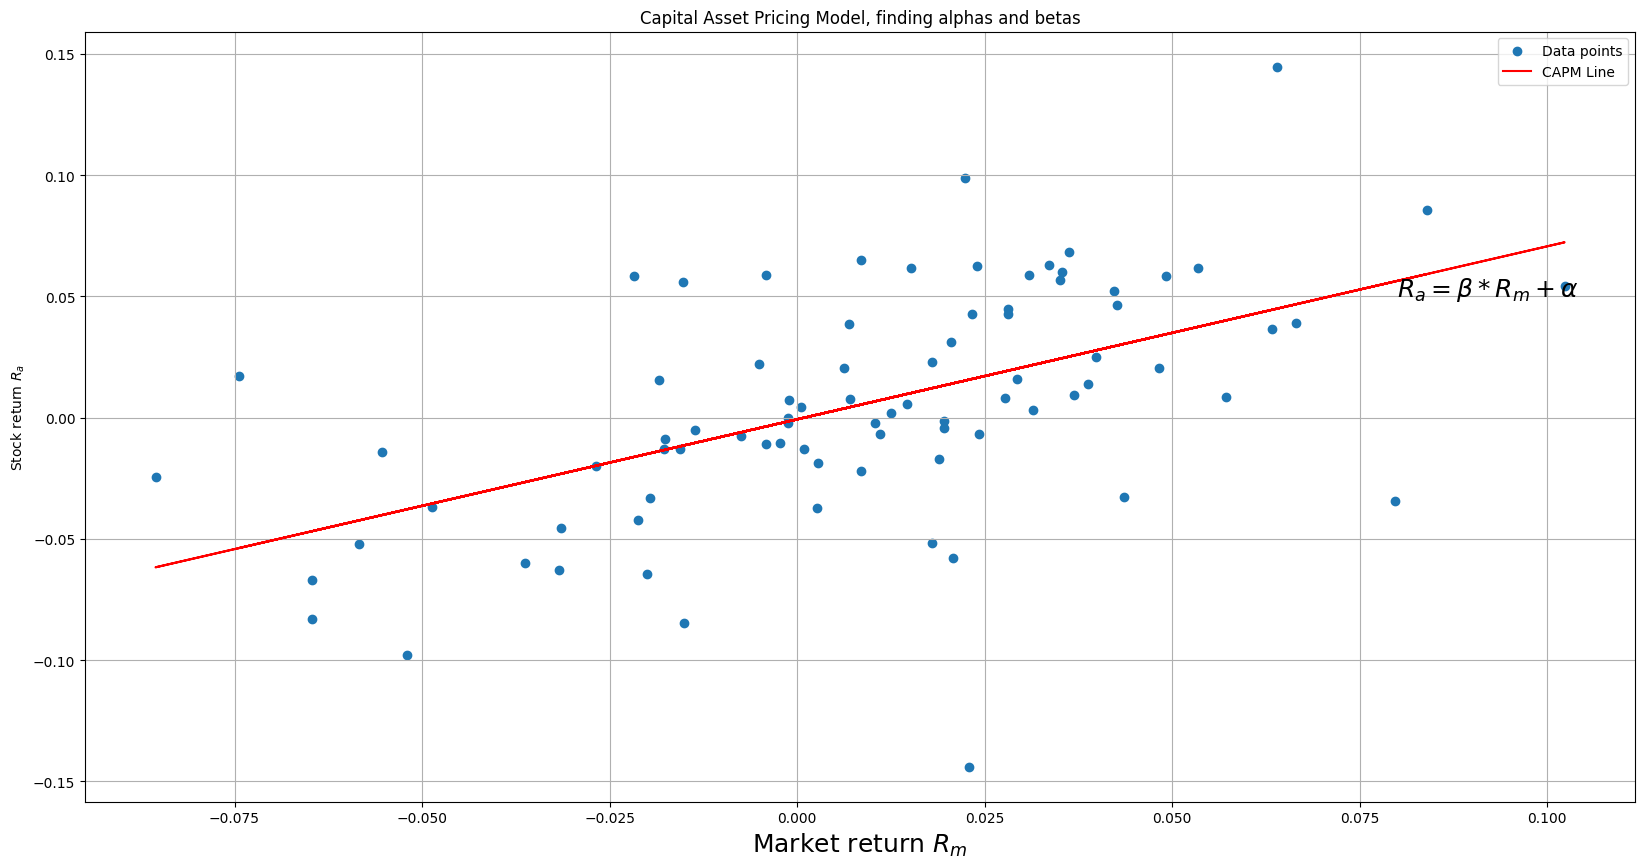

In [ ]:
if __name__ == '__main__':

  capm = CAPM(['IBM','^GSPC'], '2010-01-01', '2017-01-01') # Note that ^GSPC stands for S&P 500 market data
  capm.initialize()
  capm.calculate_beta()
  capm.regression()

#3. Picking the right currency after arbitrage